---
### Example notebook to demonstrate approximate contour binning on A1314 XMM data

[210701 - AMS] - notebook created

---

In [1]:
import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.utils.exceptions import AstropyWarning

import numpy as np
import pylab as pl
import json
import warnings
from scipy.optimize import minimize
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Wedge

warnings.simplefilter('ignore', category=AstropyWarning)

Import custom functions for approximate contour binning:

In [2]:
from PyContourBin.contour_binning import *

Set plotting parameters:

In [3]:
pl.rcParams['figure.figsize'] = [16,16]
pl.rcParams['figure.dpi'] = 150

---
### Read in configuration parameters from config file

In [4]:
config_dict, config = parse_config('configs/config_a1314.cfg')

obs_image      = config_dict['data']['obs_image']
exptime        = config_dict['data']['exptime']
t              = config_dict['binning']['threshold']
maxbin         = config_dict['binning']['maxbin']
constraint     = config_dict['binning']['constraint']
xmmsas         = config_dict['sas']['issas']

If a maximum radius is set, check that the xray centroid is specified:

In [5]:
if config_dict['binning']['maxrad']!=None:
    maxrad = config_dict['binning']['maxrad']
    try:
        xraycen = config_dict['binning']['centre']
    except:
        print("Maximum radius for binning requires that the Xray centre is specified. Please specify this in the config file or set 'maxrad: None'.")
        exit() 

---
### Read the data from the FITS file

In [6]:
obs_hdu = fits.open(obs_image)[0]
obs_wcs = WCS(obs_hdu.header)

In [7]:
data = obs_hdu.data

pixsize = obs_hdu.header['CDELT2'] # degrees
pixarea = pixsize**2

Perform maximum radius masking if required:

In [8]:
data = obs_hdu.data
if maxrad>0.:
    censky = SkyCoord(xraycen.split()[0], xraycen.split()[1], frame='icrs')
    cenpix = obs_wcs.world_to_pixel(censky)
    maxradpix = maxrad/(pixsize*60.)
        
    h, w = data.shape
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - cenpix[0])**2 + (Y-cenpix[1])**2)
    data[np.where(dist_from_center>maxradpix)] = 0

Plot the input data for the contour binning algorithm:

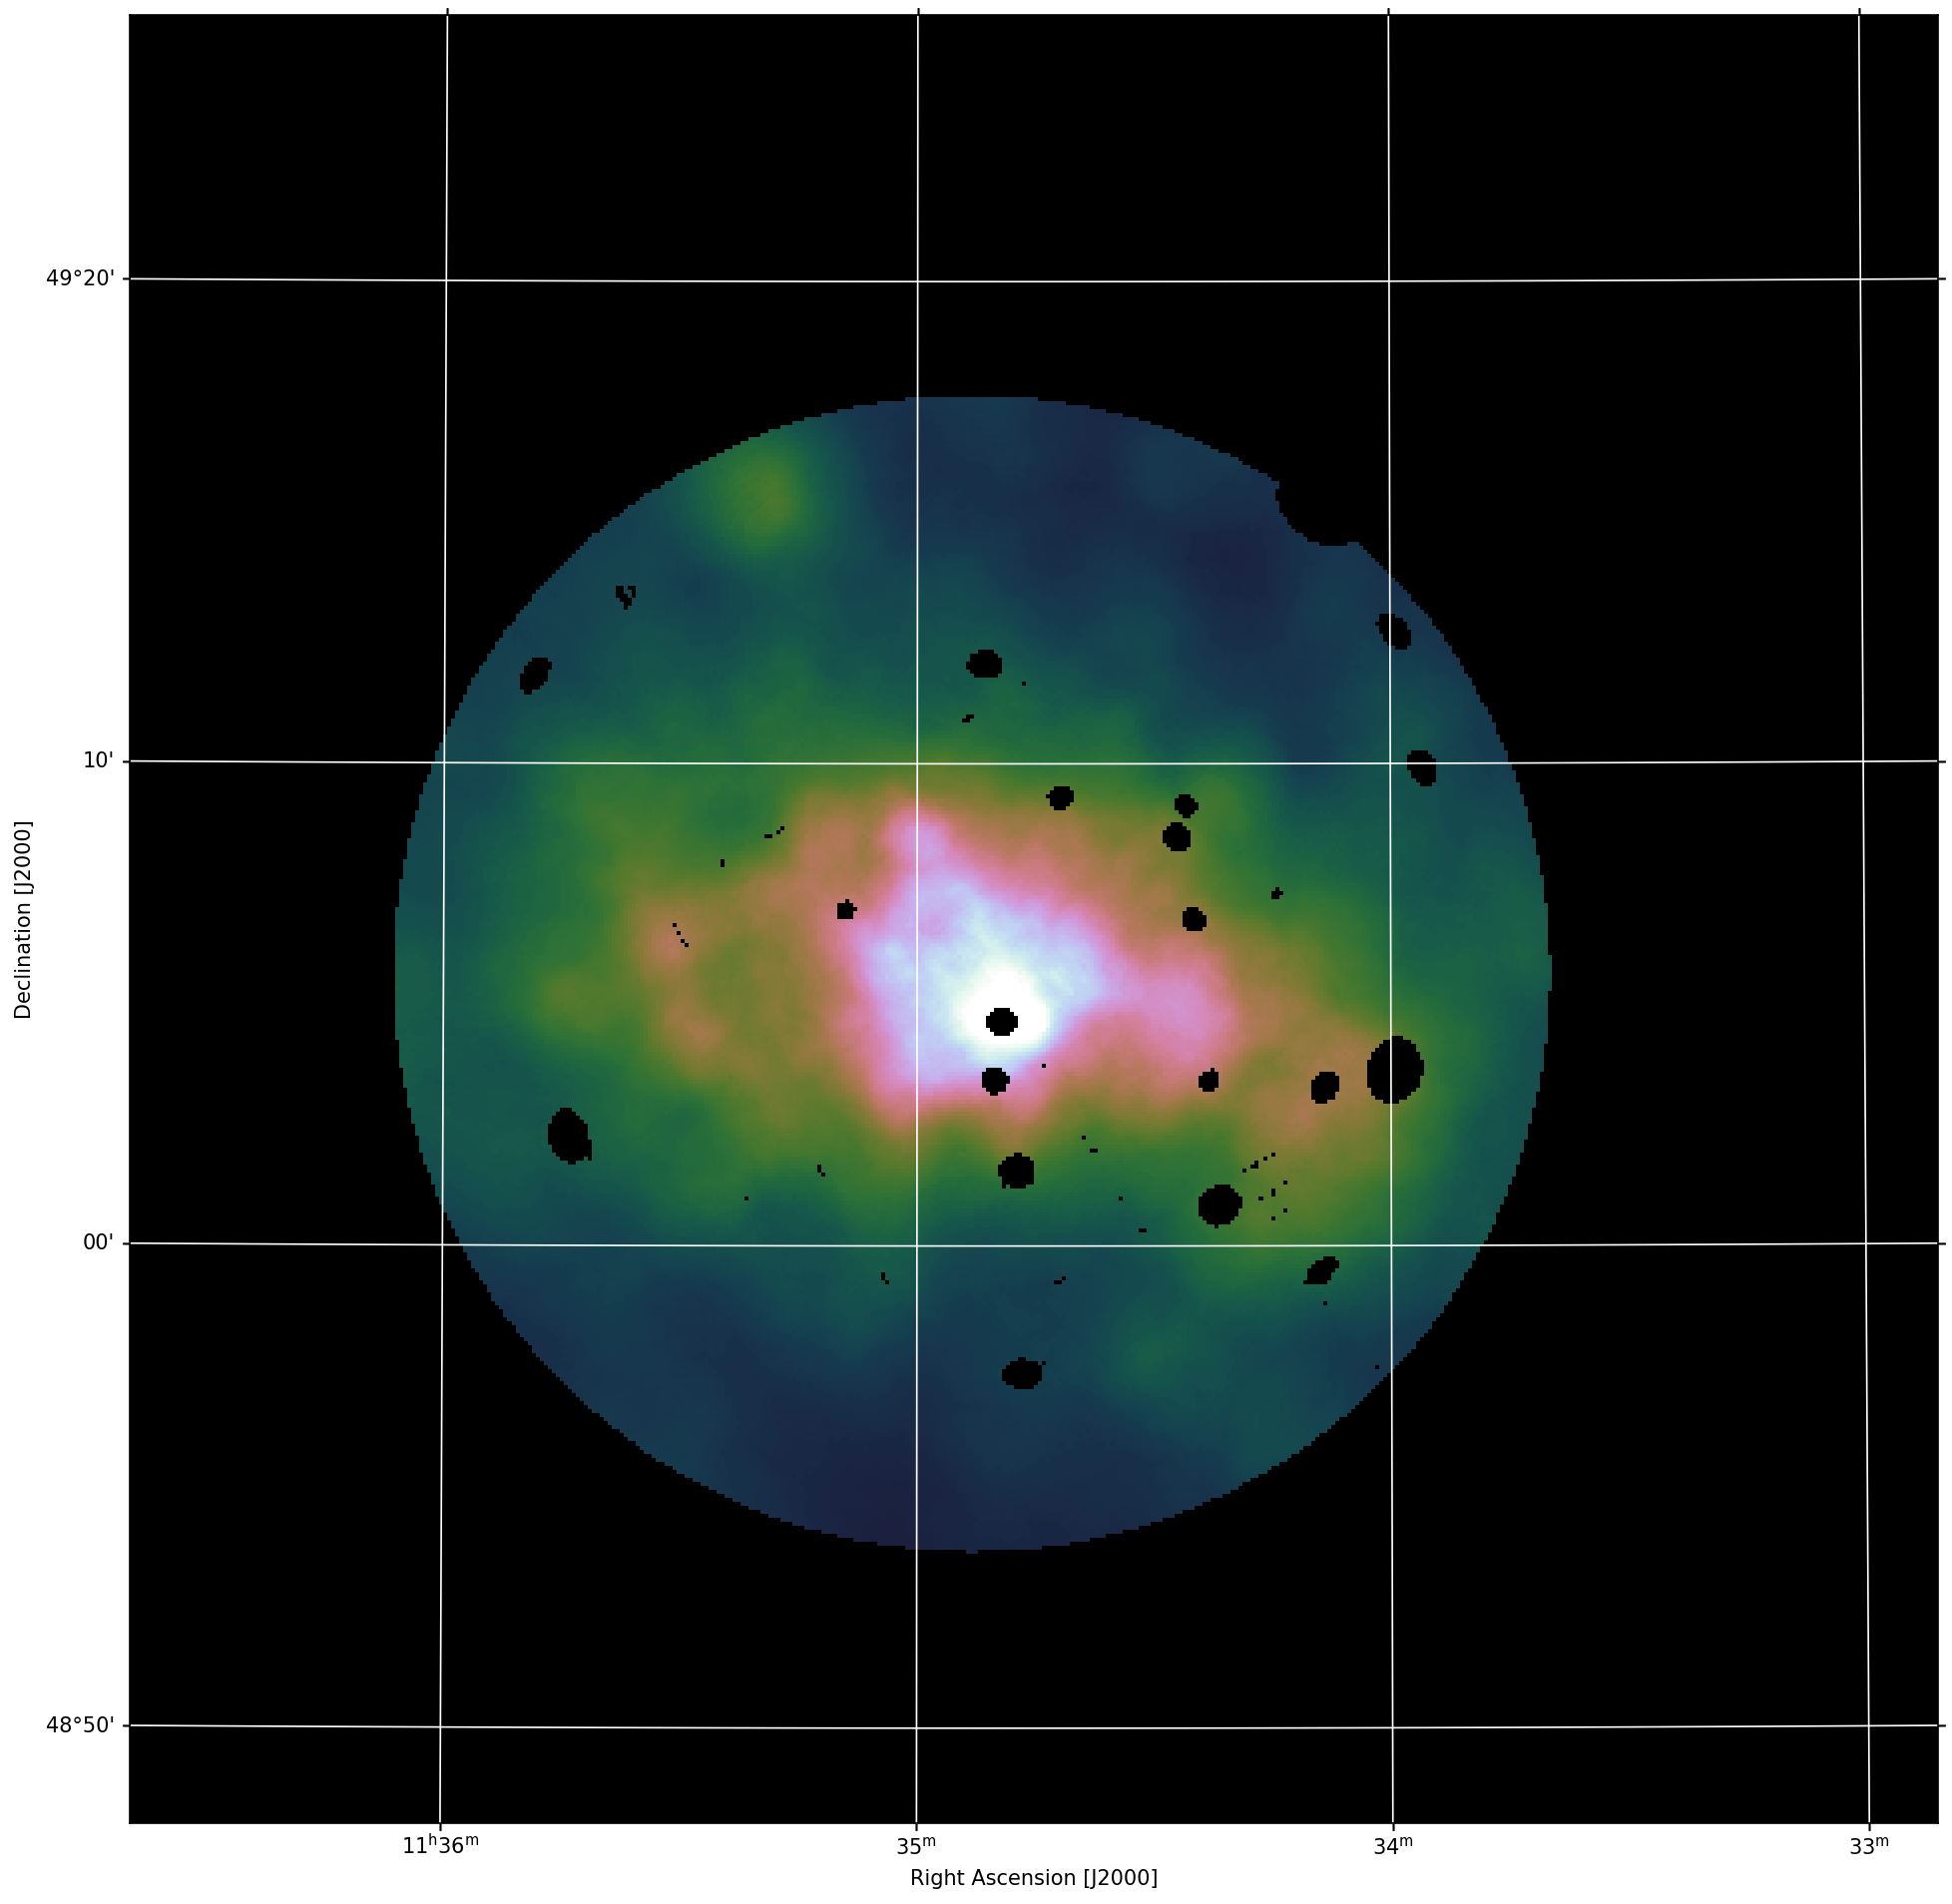

In [9]:
pl.subplot(111, projection=obs_wcs)
pl.imshow(data, origin='lower', vmin=0, vmax=30.0, cmap='cubehelix')
pl.grid(color='white', ls='solid')
pl.xlabel('Right Ascension [J2000]')
pl.ylabel('Declination [J2000]')

---
### Run the contour binning

In [10]:
threshold = t/(exptime*pixarea)
mask, bins = contour_binning(data, maxbin=maxbin, threshold=threshold, constraint=constraint, maxrad=maxradpix, xraycen=cenpix, verbose=False)

100%|██████████| 5/5 [03:06<00:00, 37.23s/it]


Plot the contour bin regions from the initial pass:

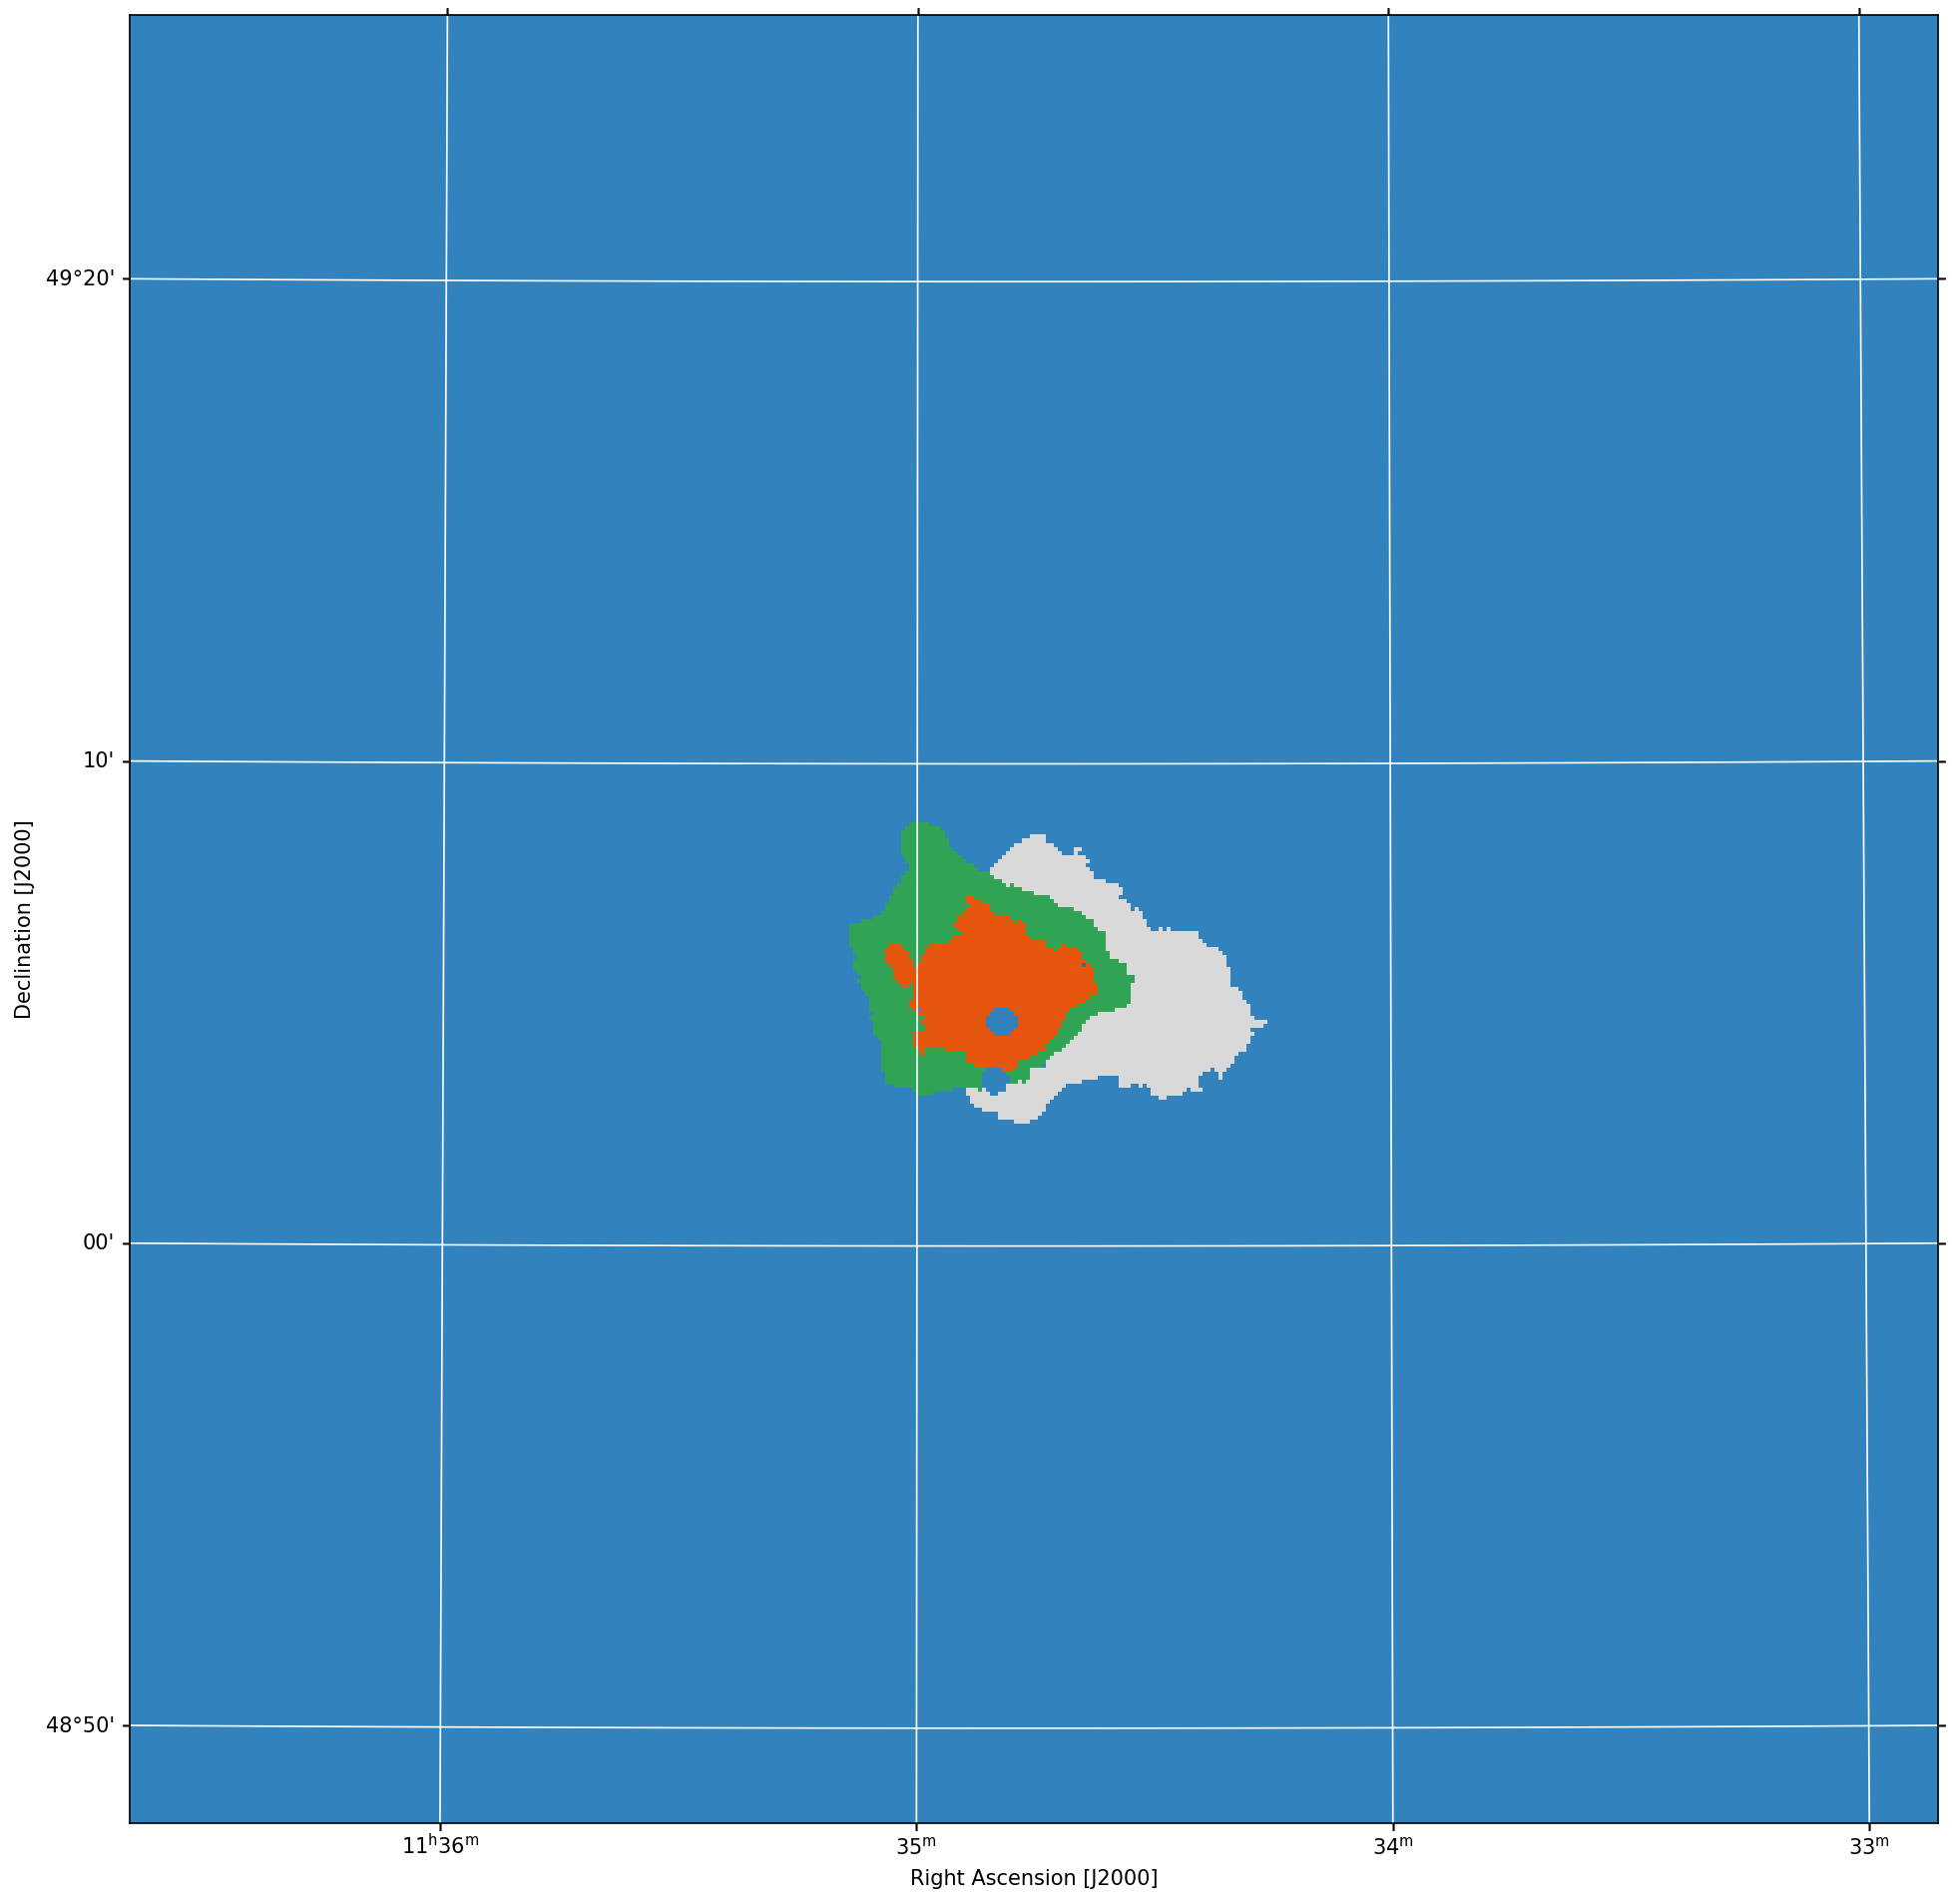

In [11]:
pl.subplot(111, projection=obs_wcs)
pl.imshow(mask, origin='lower', cmap='tab20c')
pl.grid(color='white', ls='solid')
pl.xlabel('Right Ascension [J2000]')
pl.ylabel('Declination [J2000]')

---
### Clean the contour bins

In [12]:
initial_mask = mask.copy()
initial_bins = bins.copy()
    
mask, bins = clean_bins(data, mask, bins, threshold=threshold)

Re-order the bin numbering after cleaning:

In [13]:
cleaned_mask = mask.copy()
cleaned_bins = bins.copy()

mask, bins = reorder_bins(mask, bins)

In [14]:
print("After cleaning there are {} contour bins".format(np.count_nonzero(bins)))
print(bins)

After cleaning there are 3 contour bins
[153.16793823 149.84059143 146.62393188   0.           0.        ]


Plot the cleaned and reordered bins:

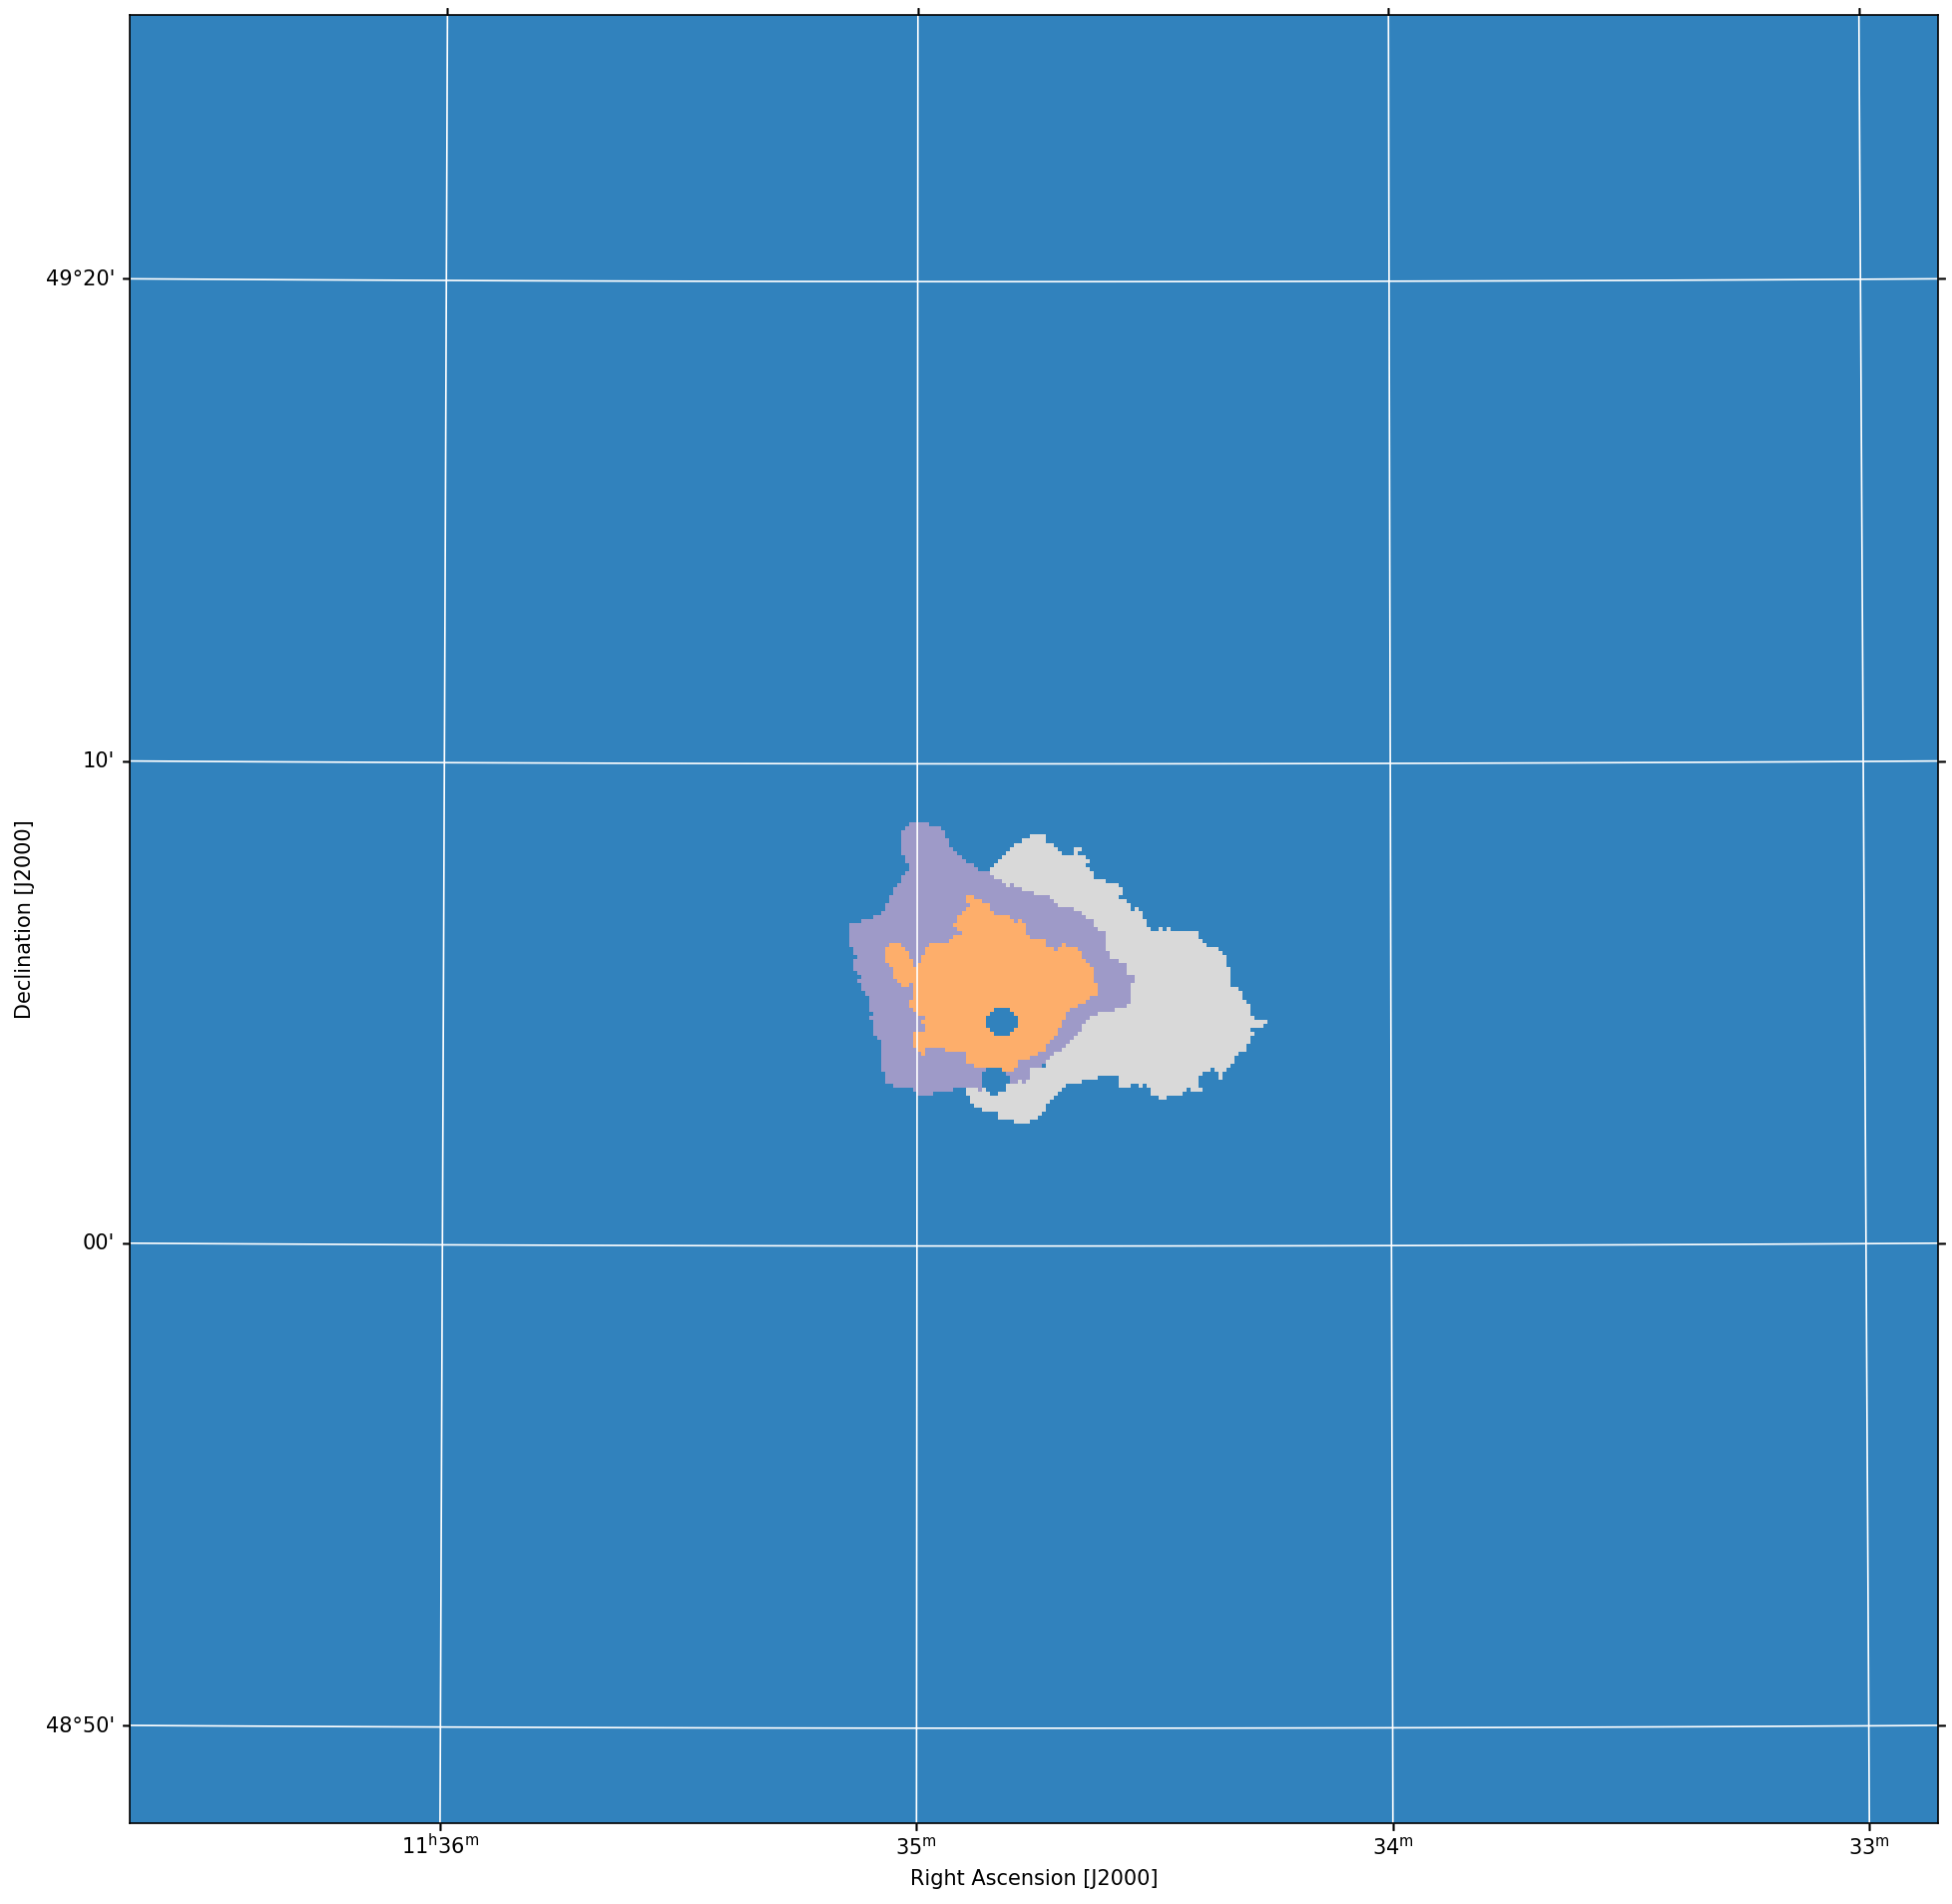

In [15]:
pl.subplot(111, projection=obs_wcs)
pl.imshow(mask, origin='lower', cmap='tab20c')
pl.grid(color='white', ls='solid')
pl.xlabel('Right Ascension [J2000]')
pl.ylabel('Declination [J2000]')

---
### Demonstrate the edge finding for region extraction

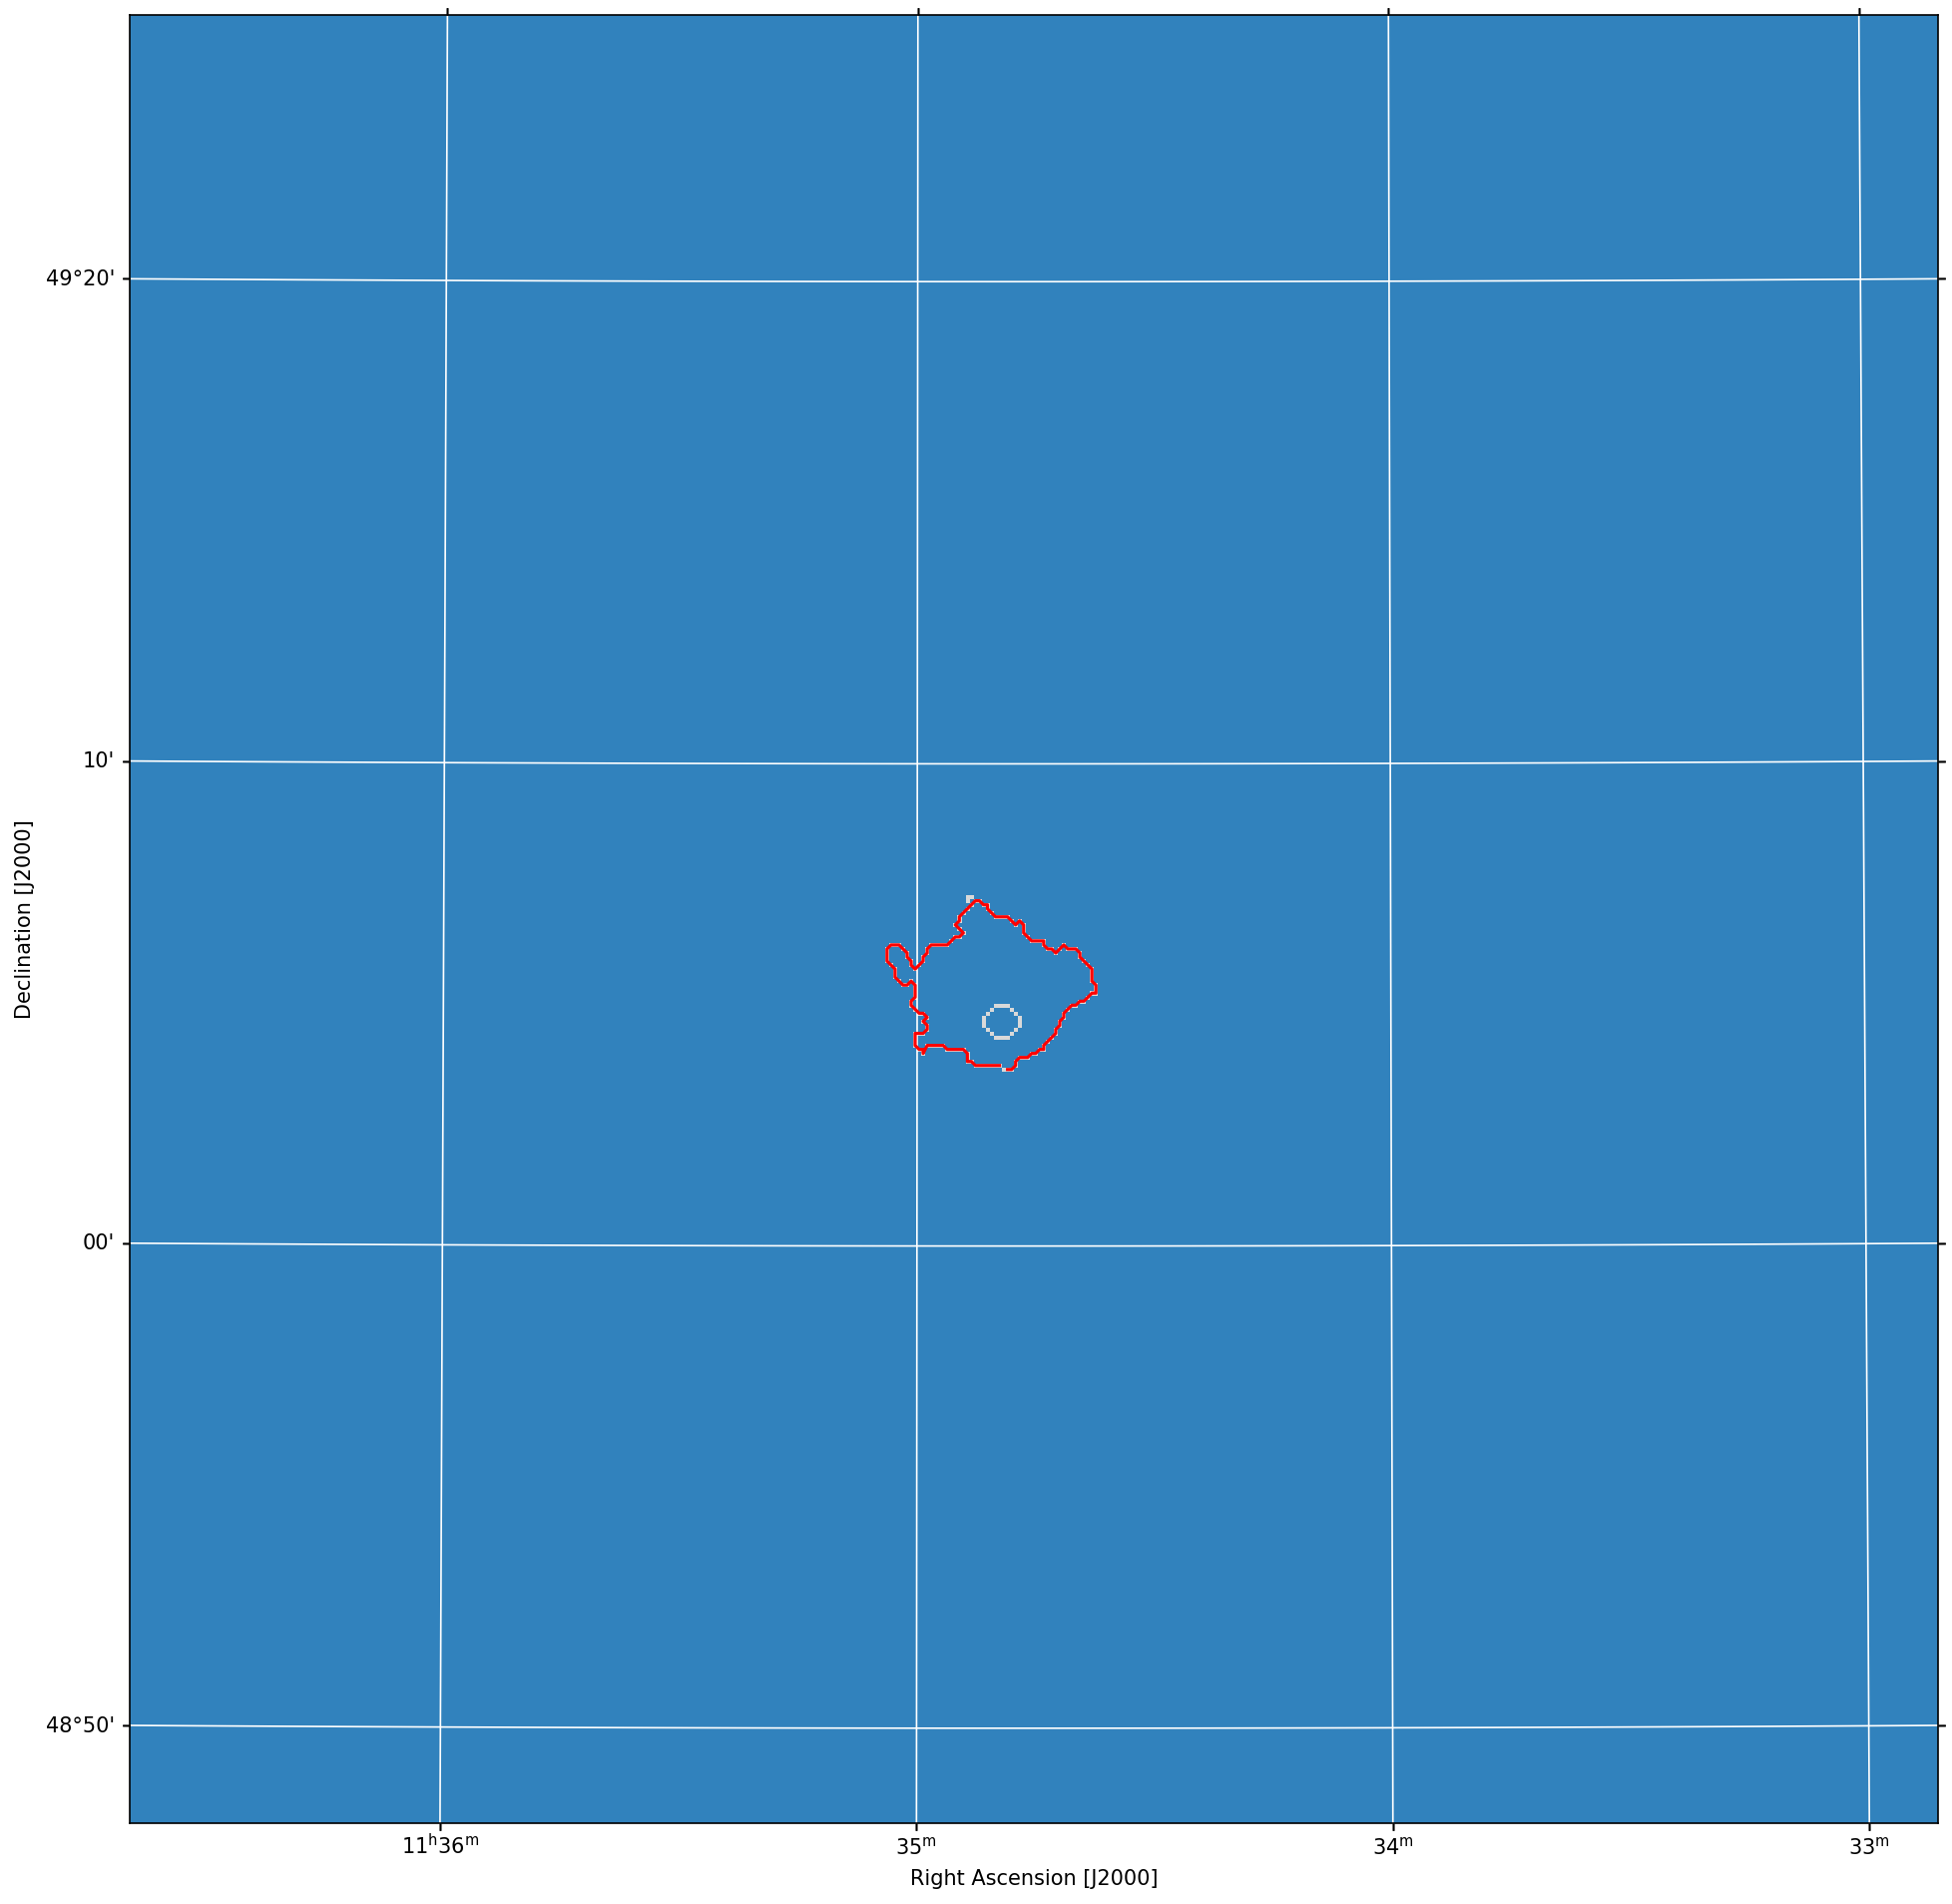

In [16]:
edge = find_edge(mask,region=1)
poly_pix = order_edge(edge)

pl.subplot(111, projection=obs_wcs)
pl.imshow(edge, origin='lower', cmap='tab20c')
pl.plot(poly_pix[:,1],poly_pix[:,0],c='r')
pl.grid(color='white', ls='solid')
pl.xlabel('Right Ascension [J2000]')
pl.ylabel('Declination [J2000]')

Extract regions for all the bins:

In [17]:
for i in tqdm(range(len(bins))):
    edge = find_edge(mask,region=i+1)
    if np.count_nonzero(edge)>0:
        poly_pix = order_edge(edge)
        poly_sky = obs_wcs.pixel_to_world(poly_pix[:,1], poly_pix[:,0])

        # JSON output:
        polygon = {'edge_'+str(i+1) : poly_sky.to_string()}
        with open('regions/edge_'+str(i+1)+'.json', 'w') as f:
            json.dump(polygon, f)

        # DS9 output:
        polygon = 'polygon('+','.join(' '.join(poly_sky.to_string()).split())+')'
        with open('regions/edge_'+str(i+1)+'.reg', 'w') as f:
            f.write('# Region file format: DS9 version 4.1 \n')
            f.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
            f.write('fk5 \n')
            f.write(polygon)
     

100%|██████████| 5/5 [00:01<00:00,  2.50it/s]
